<a href="https://colab.research.google.com/github/SonnetSaif/vision-transformer-from-scratch_PyTorch/blob/main/vision_transformer_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00


In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import Resize, ToTensor

In [38]:
to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

In [4]:
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))

100%|██████████| 791918971/791918971 [00:20<00:00, 37869133.34it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16389472.73it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


# Input Embedding

In [5]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels, patch_size, embed_dim):
    super().__init__()
    self.patch = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embed_dim,
        kernel_size=patch_size,
        stride=patch_size
    )

  def forward(self, x):
    # Flatten along dim = 2 to maintain channel dimension.
    patches = self.patch(x)
    print("after patch", patches.shape)
    patches = patches.flatten(2)
    print("after flatten", patches.shape)
    patches = patches.transpose(1, 2)
    print("after transpose", patches.shape)
    return patches

In [6]:
first = dataset[0][0]
print("Initial shape:", first.shape)
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("after unsqueeze: ", sample_datapoint.shape)
embedding = PatchEmbedding(3, 8, 128)(sample_datapoint)
print("final Patches shape: ", embedding.shape)

Initial shape: torch.Size([3, 144, 144])
after unsqueeze:  torch.Size([1, 3, 144, 144])
after patch torch.Size([1, 128, 18, 18])
after flatten torch.Size([1, 128, 324])
after transpose torch.Size([1, 324, 128])
final Patches shape:  torch.Size([1, 324, 128])


# Multi-Head Attention

Attention

In [7]:
class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, n_heads, dropout):
    super().__init__()
    self.n_heads = n_heads
    self.attention = torch.nn.MultiheadAttention(embed_dim = embed_dim,
                                                 num_heads = n_heads,
                                                 dropout = dropout)

    self.q = nn.Linear(embed_dim, embed_dim)
    self.k = nn.Linear(embed_dim, embed_dim)
    self.v = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.q(x)
    v = self.q(x)
    attention_output, attention_output_weights = self.attention(q, k, v)
    return attention_output

In [8]:
AttentionBlock(embed_dim=128, n_heads=4, dropout=0.)
# AttentionBlock(128, 4, 0.)

AttentionBlock(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (q): Linear(in_features=128, out_features=128, bias=True)
  (k): Linear(in_features=128, out_features=128, bias=True)
  (v): Linear(in_features=128, out_features=128, bias=True)
)

Layer Normalization

In [9]:
class LayerNorm(nn.Module):
  def __init__(self, embed_dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.fn = fn

  def forward(self, x):
    return self.fn(self.norm(x))

In [10]:
norm = LayerNorm(128, AttentionBlock(embed_dim=128, n_heads=4, dropout=0.))

Feed Forward

In [11]:
class FeedForward(nn.Module):
  def __init__(self, embed_dim, hidden_dim, dropout):
    super().__init__()
    self.feedForward = nn.Sequential(
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.feedForward(x)

In [12]:
feedForward = FeedForward(embed_dim=128, hidden_dim=256, dropout=0.)

Residuals

In [13]:
class Residuals(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    res = x
    x = self.fn(x)
    x += res
    return x

In [14]:
residual = Residuals(AttentionBlock(embed_dim=128, n_heads=4, dropout=0.))

In [27]:
embed_dim = 128
n_head = 4
dropout = 0.1
patch_size = 4
in_channels = 3
img_size = 144
n_layers = 12
out_dim = 37

In [28]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=in_channels, img_size=img_size, patch_size=patch_size, emb_dim=embed_dim,
                n_layers=n_layers, out_dim=out_dim, dropout=dropout, heads=n_head):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch, patch_size=patch_size, embed_dim=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                Residuals(LayerNorm(emb_dim, AttentionBlock(emb_dim, n_heads = heads, dropout = dropout))),
                Residuals(LayerNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])

In [26]:
model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))

ViT(
  (patch_embedding): PatchEmbedding(
    (patch): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Residuals(
        (fn): LayerNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): AttentionBlock(
            (attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): Residuals(
        (fn): LayerNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (feedForward): Sequential(
              (0): Linear(in_features=32, out_features=32, bias=True)
              (1): GELU(approximate='non

tensor([[ 0.5842,  0.3859,  0.4894, -0.1650,  0.1108,  0.5888,  0.2639,  0.7961,
          0.6381,  0.4175,  0.4670,  0.5165,  0.5790, -0.2606, -0.8907,  0.8122,
          0.2977,  0.5650, -0.2435, -0.3111, -0.2397, -0.1656,  0.7911,  0.0830,
         -0.2998,  0.5690,  0.6094,  0.3875,  0.0657, -0.8327,  1.2116, -0.0311,
         -0.0510,  0.1667,  0.2850,  0.8964, -0.0488]],
       grad_fn=<AddmmBackward0>)

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

print(len(train_loader.dataset))
print(len(test_loader.dataset))

2944
736


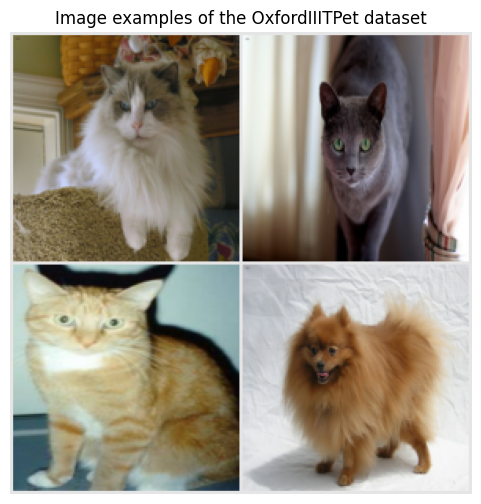

In [43]:
# Visualize some examples
NUM_IMAGES = 4
examples = torch.stack([test[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.title("Image examples of the OxfordIIITPet dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [49]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

In [ ]:
# Visualize the image patches
img_patches = img_to_patch(examples, patch_size=8, flatten_channels=False)

fig, ax = plt.subplots(examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=4, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [ ]:
import torch.optim as optim
import numpy as np
num_epochs = 100

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())